In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import random
import cv2
import sys
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def load_from_dataset (path , img_size_w , img_size_h):
  data = []
  for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img,(img_size_w,img_size_h))
    data.append(img)
  return data

In [4]:
class Data(Dataset):
    def __init__(self, device, img_size_w = 224, img_size_h = 224, mode='train', train_transform=None, val_transform=None):
        self.img_size_w = img_size_w

        self.img_size_h = img_size_h

        self.X_train, self.y_train, self.X_test, self.y_test = None, None, None, None

        self.mode = mode

        benign_path = "../data/benign/*.jpg"
        malignant_path = "../data/malignant/*.jpg"

        benign = load_from_dataset (benign_path , img_size_w , img_size_h)
        malignant = load_from_dataset (malignant_path , img_size_w , img_size_h)

        benign = np.array(benign , dtype=np.float32)
        malignant = np.array(malignant , dtype=np.float32)
        print (f'dataset shape is : {benign.shape}')

        benign_labels = np.zeros(benign.shape[0], dtype=np.float32)
        malignant_labels = np.full(malignant.shape[0], 1.0)

        self.images = np.concatenate((benign, malignant), axis=0)
        self.labels = np.concatenate((benign_labels, malignant_labels))

        self.train_transform = train_transform if train_transform else transforms.Compose([
            transforms.ToPILImage(),
            #transforms.Resize((img_size_h, img_size_w)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.val_transform = val_transform if val_transform else transforms.Compose([
            transforms.ToPILImage(),
            #transforms.Resize((img_size_h, img_size_w)),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def train_val_split(self):
        self.X_train, self.X_test, self.y_train, self.y_test = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

    def __len__(self):
        if self.mode == 'train':
          return self.X_train.shape[0]
        elif self.mode == 'val':
          return self.X_test.shape[0]

    def __getitem__(self, idx):
        if self.mode == 'train':
            image, label = self.X_train[idx], self.y_train[idx]
            image = self.train_transform(image)
        elif self.mode == 'val':
            image, label = self.X_test[idx], self.y_test[idx]
            image = self.val_transform(image)

        label = torch.tensor(label, dtype=torch.float32).to(device)
        return {'image': image, 'label': label}

    def normalize(self):
        self.images = self.images/255.0

In [5]:
class ToTensorAndMove: 
    def __init__(self, device): 
        self.to_tensor = transforms.ToTensor() 
        self.device = device 
    def __call__(self, img): 
        tensor = self.to_tensor(img) 
        return tensor.to(self.device)

In [6]:
custom_train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])

custom_val_transform = transforms.Compose([
    transforms.ToPILImage(),
    ToTensorAndMove(device),
])

In [7]:
class SkinCancerCNN(nn.Module):
    def __init__(self):
        super(SkinCancerCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1)  
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)  
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1) 
        self.pool3 = nn.MaxPool2d(kernel_size=1, stride=2)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(2 * 2 * 128, 64) 
        self.fc2 = nn.Linear(64, 32)  
        self.fc3 = nn.Linear(32, 2)   

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        
        x = self.flatten(x)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  
        return x

In [13]:
in_channels = 3
num_classes = 2
learning_rate = 3e-4 # karpathy's constant
batch_size = 256
num_epochs = 100

In [20]:
model = SkinCancerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
def train_model(model, optimizer, criterion, train_loader, val_loader, dataset, num_epochs=10, device='cuda'):
    model.to(device)
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)
    
    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        dataset.mode = 'train'
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
            for batch in train_loader:
                images, labels = batch['image'].to(device), batch['label'].to(device)
                
                optimizer.zero_grad()  
                outputs = model(images)
                loss = criterion(outputs, labels.long())  
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                pbar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)
                pbar.update(1)
        
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100. * correct / total
        # print(f"Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        train_accuracies.append(train_accuracy)
        train_losses.append(avg_train_loss)
        
        model.eval()  
        dataset.mode = 'val'
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
                for batch in val_loader:
                    images, labels = batch['image'].to(device), batch['label'].to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels.long())
                    
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

                    pbar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)
                    pbar.update(1)
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100. * correct / total
        # print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
        print("-" * 30)
        val_accuracies.append(val_accuracy)
        val_losses.append(avg_val_loss)
        mean_loss = sum(train_losses) / len(train_losses)
        mean_loss = round(mean_loss, 2)
        scheduler.step(mean_loss)
    
    return train_accuracies, train_losses, val_accuracies, val_losses


In [11]:
dataset = train_dataset = Data(device, img_size_w=28, img_size_h=28, mode='train', 
                               train_transform=custom_train_transform, val_transform=custom_val_transform)

dataset.normalize()
dataset.train_val_split()

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

dataset shape is : (1800, 28, 28, 3)


In [21]:
train_accuracies, train_losses, val_accuracy, val_losses = train_model(model, optimizer, criterion, 
                                                                       train_dataloader, test_dataloader, dataset, num_epochs=num_epochs, device=device)

Epoch [1/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.14batch/s, accuracy=56.8, loss=0.681]


------------------------------
Epoch [2/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.89batch/s, accuracy=56.8, loss=0.678]


------------------------------
Epoch [3/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.51batch/s, accuracy=56.8, loss=0.665]


------------------------------
Epoch [4/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.63batch/s, accuracy=73.9, loss=0.633]


------------------------------
Epoch [5/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.75batch/s, accuracy=70.5, loss=0.533]


------------------------------
Epoch [6/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.45batch/s, accuracy=76.4, loss=0.516]


------------------------------
Epoch [7/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.49batch/s, accuracy=77.1, loss=0.425]


------------------------------
Epoch [8/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.51batch/s, accuracy=78.5, loss=0.412]


------------------------------
Epoch [9/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.29batch/s, accuracy=79.4, loss=0.4]  


------------------------------
Epoch [10/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.57batch/s, accuracy=78.6, loss=0.435]


------------------------------
Epoch [11/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.19batch/s, accuracy=80.5, loss=0.388]


------------------------------
Epoch [12/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.33batch/s, accuracy=78.6, loss=0.435]


------------------------------
Epoch [13/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.49batch/s, accuracy=77.3, loss=0.403]


------------------------------
Epoch [14/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.36batch/s, accuracy=78.9, loss=0.406]


------------------------------
Epoch [15/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.26batch/s, accuracy=78.8, loss=0.403]


------------------------------
Epoch [16/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.68batch/s, accuracy=80.8, loss=0.392]


------------------------------
Epoch [17/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.87batch/s, accuracy=79.1, loss=0.384]


------------------------------
Epoch [18/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.21batch/s, accuracy=81.1, loss=0.385]


------------------------------
Epoch [19/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.49batch/s, accuracy=80.8, loss=0.391]


------------------------------
Epoch [20/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.81batch/s, accuracy=80.2, loss=0.378]


------------------------------
Epoch [21/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.20batch/s, accuracy=80.6, loss=0.378]


------------------------------
Epoch [22/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.30batch/s, accuracy=79.5, loss=0.411]


------------------------------
Epoch [23/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.70batch/s, accuracy=80.6, loss=0.39] 


------------------------------
Epoch [24/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.36batch/s, accuracy=80.3, loss=0.372]


------------------------------
Epoch [25/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.67batch/s, accuracy=81.2, loss=0.375]


------------------------------
Epoch [26/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.89batch/s, accuracy=81.2, loss=0.37] 


------------------------------
Epoch [27/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.63batch/s, accuracy=80.3, loss=0.382]


------------------------------
Epoch [28/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.58batch/s, accuracy=80.8, loss=0.37] 


------------------------------
Epoch [29/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.07batch/s, accuracy=80.2, loss=0.366]


------------------------------
Epoch [30/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.80batch/s, accuracy=80, loss=0.386]  


------------------------------
Epoch [31/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.92batch/s, accuracy=81.1, loss=0.365]


------------------------------
Epoch [32/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.21batch/s, accuracy=79.4, loss=0.411]


------------------------------
Epoch [33/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.76batch/s, accuracy=79.8, loss=0.364]


------------------------------
Epoch [34/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.98batch/s, accuracy=80.3, loss=0.407]


------------------------------
Epoch [35/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.45batch/s, accuracy=80.8, loss=0.363]


------------------------------
Epoch [36/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.90batch/s, accuracy=81.5, loss=0.361]


------------------------------
Epoch [37/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.19batch/s, accuracy=80.3, loss=0.363]


------------------------------
Epoch [38/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.78batch/s, accuracy=81.4, loss=0.361]


------------------------------
Epoch [39/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.70batch/s, accuracy=81.1, loss=0.368]


------------------------------
Epoch [40/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.47batch/s, accuracy=80.6, loss=0.406]


------------------------------
Epoch [41/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.63batch/s, accuracy=80.9, loss=0.358]


------------------------------
Epoch [42/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.58batch/s, accuracy=81.5, loss=0.375]


------------------------------
Epoch [43/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.56batch/s, accuracy=79.2, loss=0.422]


------------------------------
Epoch [44/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.15batch/s, accuracy=81.1, loss=0.354]


------------------------------
Epoch [45/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.15batch/s, accuracy=79.2, loss=0.367]


------------------------------
Epoch [46/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.82batch/s, accuracy=81.2, loss=0.357]


------------------------------
Epoch [47/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.45batch/s, accuracy=80.2, loss=0.41] 


------------------------------
Epoch [48/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.54batch/s, accuracy=80.5, loss=0.398]


------------------------------
Epoch [49/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.32batch/s, accuracy=81.2, loss=0.358]


------------------------------
Epoch [50/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.13batch/s, accuracy=82.6, loss=0.347]


------------------------------
Epoch [51/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.21batch/s, accuracy=81.8, loss=0.368]


------------------------------
Epoch [52/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.89batch/s, accuracy=81.7, loss=0.379]


------------------------------
Epoch [53/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.19batch/s, accuracy=81.8, loss=0.374]


------------------------------
Epoch [54/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.20batch/s, accuracy=81.8, loss=0.359]


------------------------------
Epoch [55/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.71batch/s, accuracy=82.1, loss=0.347]


------------------------------
Epoch [56/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.93batch/s, accuracy=82.1, loss=0.364]


------------------------------
Epoch [57/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.52batch/s, accuracy=82.3, loss=0.368]


------------------------------
Epoch [58/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.86batch/s, accuracy=81.5, loss=0.387]


------------------------------
Epoch [59/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.41batch/s, accuracy=81.5, loss=0.393]


------------------------------
Epoch [60/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.62batch/s, accuracy=82.6, loss=0.344]


------------------------------
Epoch [61/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.90batch/s, accuracy=82, loss=0.373]  


------------------------------
Epoch [62/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.83batch/s, accuracy=82.9, loss=0.352]


------------------------------
Epoch [63/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.41batch/s, accuracy=82.9, loss=0.356]


------------------------------
Epoch [64/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.31batch/s, accuracy=82.1, loss=0.36] 


------------------------------
Epoch [65/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.90batch/s, accuracy=82.3, loss=0.367]


------------------------------
Epoch [66/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.45batch/s, accuracy=81.7, loss=0.364]


------------------------------
Epoch [67/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.95batch/s, accuracy=81.8, loss=0.4]


------------------------------
Epoch [68/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.75batch/s, accuracy=81.8, loss=0.38] 


------------------------------
Epoch [69/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.76batch/s, accuracy=80, loss=0.35]   


------------------------------
Epoch [70/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.63batch/s, accuracy=82, loss=0.37]   


------------------------------
Epoch [71/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.56batch/s, accuracy=80.6, loss=0.414]


------------------------------
Epoch [72/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.14batch/s, accuracy=82.4, loss=0.367]


------------------------------
Epoch [73/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.22batch/s, accuracy=82.4, loss=0.377]


------------------------------
Epoch [74/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.08batch/s, accuracy=83, loss=0.343]  


------------------------------
Epoch [75/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.29batch/s, accuracy=74.8, loss=0.521]


------------------------------
Epoch [76/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.97batch/s, accuracy=82.7, loss=0.336]


------------------------------
Epoch [77/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.11batch/s, accuracy=82.4, loss=0.356]


------------------------------
Epoch [78/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.35batch/s, accuracy=82.9, loss=0.363]


------------------------------
Epoch [79/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.96batch/s, accuracy=83.9, loss=0.352]


------------------------------
Epoch [80/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.92batch/s, accuracy=84.1, loss=0.355]


------------------------------
Epoch [81/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.36batch/s, accuracy=83.6, loss=0.359]


------------------------------
Epoch [82/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.70batch/s, accuracy=83.8, loss=0.35] 


------------------------------
Epoch [83/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.27batch/s, accuracy=82.9, loss=0.363]


------------------------------
Epoch [84/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.55batch/s, accuracy=83.9, loss=0.356]


------------------------------
Epoch [85/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.64batch/s, accuracy=83.8, loss=0.361]


------------------------------
Epoch [86/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.79batch/s, accuracy=83.6, loss=0.356]


------------------------------
Epoch [87/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.67batch/s, accuracy=83.8, loss=0.359]


------------------------------
Epoch [88/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.25batch/s, accuracy=84.1, loss=0.35] 


------------------------------
Epoch [89/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.71batch/s, accuracy=82.9, loss=0.361]


------------------------------
Epoch [90/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.83batch/s, accuracy=84.1, loss=0.353]


------------------------------
Epoch [91/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.51batch/s, accuracy=83.8, loss=0.351]


------------------------------
Epoch [92/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.27batch/s, accuracy=84.2, loss=0.354]


------------------------------
Epoch [93/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.58batch/s, accuracy=83.3, loss=0.359]


------------------------------
Epoch [94/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.17batch/s, accuracy=83.8, loss=0.358]


------------------------------
Epoch [95/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.49batch/s, accuracy=84.1, loss=0.357]


------------------------------
Epoch [96/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.57batch/s, accuracy=84.1, loss=0.357]


------------------------------
Epoch [97/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.55batch/s, accuracy=84.1, loss=0.357]


------------------------------
Epoch [98/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.49batch/s, accuracy=84.1, loss=0.357]


------------------------------
Epoch [99/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.79batch/s, accuracy=84.1, loss=0.357]


------------------------------
Epoch [100/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.01batch/s, accuracy=84.2, loss=0.355]

------------------------------


In [16]:
def plot_metric(metric, train_metric, val_metric, epochs=50):
    plt.figure(figsize=(10, 5)) 
    plt.plot(range(1, epochs + 1), train_metric, label=f'Training {metric}', alpha=0.5) 
    plt.plot(range(1, epochs + 1), val_metric, label=f'Validation {metric}', alpha=0.5)  
    plt.xlabel('Epoch') 
    plt.ylabel(metric) 
    plt.title(f'Training and Validation {metric} Over Epochs') 
    plt.legend() 
    plt.show()

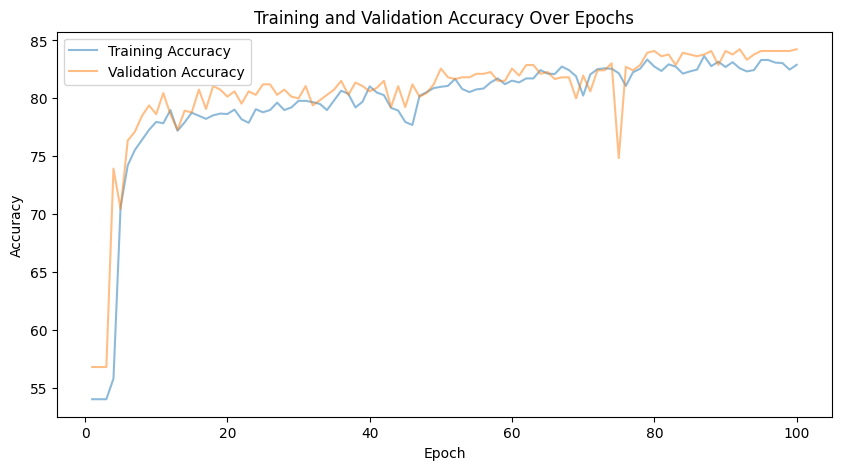

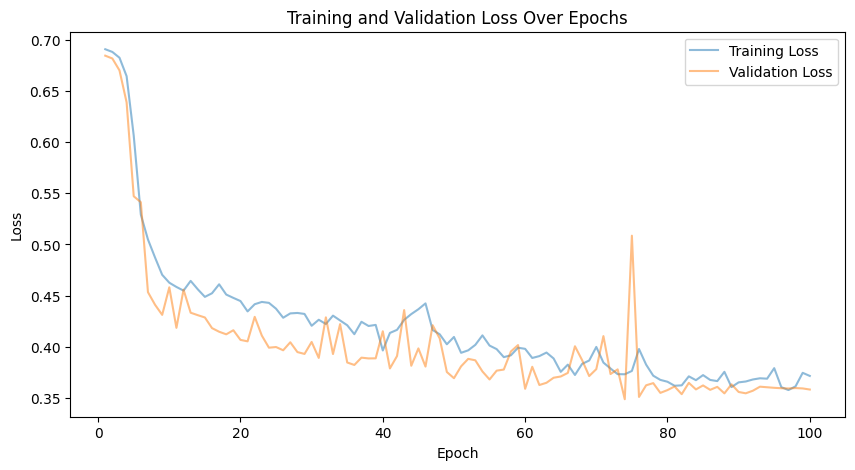

In [22]:
plot_metric('Accuracy', train_accuracies, val_accuracy, epochs=num_epochs)
plot_metric('Loss', train_losses, val_losses, epochs=num_epochs)

In [23]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))

In [31]:
class ImprovedSkinCancerCNN(nn.Module):
    def __init__(self):
        super(ImprovedSkinCancerCNN, self).__init__()
        
        self.conv1 = conv_block(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1)  
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.dropout1 = nn.Dropout(p=0.05) 
        
        self.conv2 = conv_block(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)  
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.dropout2 = nn.Dropout(p=0.05) 
        
        self.conv3 = conv_block(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1) 
        self.pool3 = nn.MaxPool2d(kernel_size=1, stride=2)
        self.dropout3 = nn.Dropout(p=0.05) 
        
        self.conv4 = conv_block(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(p=0.05) 
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(2 * 2 * 128, 128) 
        self.fc2 = nn.Linear(128, 32)  
        self.fc3 = nn.Linear(32, 2)   

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.dropout1(x) 
        
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout2(x) 
        
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.dropout3(x) 
        
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.dropout4(x) 
        
        x = self.flatten(x)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  
        return x

In [32]:
improvedModel = ImprovedSkinCancerCNN().to(device)
optimizer = optim.Adam(improvedModel.parameters(), lr=learning_rate)
train_accuracies, train_losses, val_accuracy, val_losses = train_model(improvedModel, optimizer, criterion, 
                                                                       train_dataloader, test_dataloader, dataset, 
                                                                       num_epochs=num_epochs, device=device)

Epoch [1/100]


Training:   0%|          | 0/11 [00:00<?, ?batch/s]

Validation: 100%|██████████| 3/3 [00:00<00:00,  9.88batch/s, accuracy=43.2, loss=0.699]


------------------------------
Epoch [2/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 15.97batch/s, accuracy=76.8, loss=0.614]


------------------------------
Epoch [3/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.50batch/s, accuracy=75.5, loss=0.47] 


------------------------------
Epoch [4/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.37batch/s, accuracy=78.3, loss=0.414]


------------------------------
Epoch [5/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 15.07batch/s, accuracy=81.5, loss=0.371]


------------------------------
Epoch [6/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.57batch/s, accuracy=82, loss=0.323]  


------------------------------
Epoch [7/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.00batch/s, accuracy=83.9, loss=0.327]


------------------------------
Epoch [8/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 15.00batch/s, accuracy=82.6, loss=0.337]


------------------------------
Epoch [9/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.42batch/s, accuracy=83.8, loss=0.315]


------------------------------
Epoch [10/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.71batch/s, accuracy=84.7, loss=0.321]


------------------------------
Epoch [11/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.38batch/s, accuracy=82.9, loss=0.335]


------------------------------
Epoch [12/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.61batch/s, accuracy=84.1, loss=0.319]


------------------------------
Epoch [13/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.57batch/s, accuracy=80.8, loss=0.359]


------------------------------
Epoch [14/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.55batch/s, accuracy=84.1, loss=0.324]


------------------------------
Epoch [15/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.92batch/s, accuracy=81.7, loss=0.322]


------------------------------
Epoch [16/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.21batch/s, accuracy=85.2, loss=0.312]


------------------------------
Epoch [17/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.19batch/s, accuracy=84.1, loss=0.3]  


------------------------------
Epoch [18/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.76batch/s, accuracy=83.9, loss=0.305]


------------------------------
Epoch [19/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.23batch/s, accuracy=85, loss=0.297]  


------------------------------
Epoch [20/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.21batch/s, accuracy=86.2, loss=0.294]


------------------------------
Epoch [21/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.75batch/s, accuracy=84.2, loss=0.307]


------------------------------
Epoch [22/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.56batch/s, accuracy=82.9, loss=0.313]


------------------------------
Epoch [23/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.46batch/s, accuracy=86.1, loss=0.287]


------------------------------
Epoch [24/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 15.53batch/s, accuracy=82.9, loss=0.307]


------------------------------
Epoch [25/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.82batch/s, accuracy=85.9, loss=0.291]


------------------------------
Epoch [26/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 15.62batch/s, accuracy=85, loss=0.293]


------------------------------
Epoch [27/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.76batch/s, accuracy=81.5, loss=0.32] 


------------------------------
Epoch [28/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.29batch/s, accuracy=85, loss=0.293]  


------------------------------
Epoch [29/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.44batch/s, accuracy=85.8, loss=0.287]


------------------------------
Epoch [30/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.27batch/s, accuracy=82.6, loss=0.314]


------------------------------
Epoch [31/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.95batch/s, accuracy=84.7, loss=0.294]


------------------------------
Epoch [32/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.15batch/s, accuracy=85.2, loss=0.285]


------------------------------
Epoch [33/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.97batch/s, accuracy=82, loss=0.318]  


------------------------------
Epoch [34/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.75batch/s, accuracy=84.8, loss=0.285]


------------------------------
Epoch [35/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.30batch/s, accuracy=83.8, loss=0.308]


------------------------------
Epoch [36/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.46batch/s, accuracy=83.2, loss=0.304]


------------------------------
Epoch [37/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.53batch/s, accuracy=84.8, loss=0.293]


------------------------------
Epoch [38/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.63batch/s, accuracy=83.5, loss=0.3]  


------------------------------
Epoch [39/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.71batch/s, accuracy=85.5, loss=0.297]


------------------------------
Epoch [40/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.95batch/s, accuracy=83.9, loss=0.294]


------------------------------
Epoch [41/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.04batch/s, accuracy=83.9, loss=0.297]


------------------------------
Epoch [42/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.95batch/s, accuracy=85.9, loss=0.286]


------------------------------
Epoch [43/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.96batch/s, accuracy=85, loss=0.28]   


------------------------------
Epoch [44/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.29batch/s, accuracy=84.7, loss=0.285]


------------------------------
Epoch [45/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.45batch/s, accuracy=85.9, loss=0.281]


------------------------------
Epoch [46/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.97batch/s, accuracy=86.2, loss=0.293]


------------------------------
Epoch [47/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.27batch/s, accuracy=86.1, loss=0.282]


------------------------------
Epoch [48/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.85batch/s, accuracy=85.8, loss=0.293]


------------------------------
Epoch [49/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.18batch/s, accuracy=85, loss=0.303]  


------------------------------
Epoch [50/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.87batch/s, accuracy=85.2, loss=0.302]


------------------------------
Epoch [51/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.10batch/s, accuracy=84.1, loss=0.316]


------------------------------
Epoch [52/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.64batch/s, accuracy=85.8, loss=0.301]


------------------------------
Epoch [53/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.44batch/s, accuracy=84.5, loss=0.307]


------------------------------
Epoch [54/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.89batch/s, accuracy=86.5, loss=0.284]


------------------------------
Epoch [55/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.66batch/s, accuracy=86.4, loss=0.276]


------------------------------
Epoch [56/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.49batch/s, accuracy=80.8, loss=0.394]


------------------------------
Epoch [57/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.63batch/s, accuracy=85.8, loss=0.285]


------------------------------
Epoch [58/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.63batch/s, accuracy=84.1, loss=0.321]


------------------------------
Epoch [59/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.35batch/s, accuracy=83.9, loss=0.307]


------------------------------
Epoch [60/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.26batch/s, accuracy=86.7, loss=0.277]


------------------------------
Epoch [61/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.99batch/s, accuracy=86.5, loss=0.272]


------------------------------
Epoch [62/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.38batch/s, accuracy=87.4, loss=0.271]


------------------------------
Epoch [63/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.87batch/s, accuracy=85.2, loss=0.3]  


------------------------------
Epoch [64/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.01batch/s, accuracy=86.1, loss=0.302]


------------------------------
Epoch [65/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.44batch/s, accuracy=85.9, loss=0.297]


------------------------------
Epoch [66/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.49batch/s, accuracy=84.7, loss=0.312]


------------------------------
Epoch [67/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 15.31batch/s, accuracy=86.7, loss=0.279]


------------------------------
Epoch [68/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.75batch/s, accuracy=85.2, loss=0.281]


------------------------------
Epoch [69/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.49batch/s, accuracy=87, loss=0.29]   


------------------------------
Epoch [70/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.86batch/s, accuracy=85.9, loss=0.286]


------------------------------
Epoch [71/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.45batch/s, accuracy=86.7, loss=0.29] 


------------------------------
Epoch [72/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.00batch/s, accuracy=85.9, loss=0.263]


------------------------------
Epoch [73/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.57batch/s, accuracy=86.2, loss=0.283]


------------------------------
Epoch [74/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.26batch/s, accuracy=87.6, loss=0.269]


------------------------------
Epoch [75/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.90batch/s, accuracy=86.7, loss=0.259]


------------------------------
Epoch [76/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.71batch/s, accuracy=86.8, loss=0.268]


------------------------------
Epoch [77/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.84batch/s, accuracy=86.4, loss=0.273]


------------------------------
Epoch [78/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.01batch/s, accuracy=86.7, loss=0.271]


------------------------------
Epoch [79/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.92batch/s, accuracy=86.4, loss=0.275]


------------------------------
Epoch [80/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.97batch/s, accuracy=86.5, loss=0.274]


------------------------------
Epoch [81/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.56batch/s, accuracy=86.5, loss=0.274]


------------------------------
Epoch [82/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 15.02batch/s, accuracy=86.8, loss=0.274]


------------------------------
Epoch [83/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.51batch/s, accuracy=86.8, loss=0.268]


------------------------------
Epoch [84/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.16batch/s, accuracy=86.8, loss=0.276]


------------------------------
Epoch [85/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.10batch/s, accuracy=86.7, loss=0.273]


------------------------------
Epoch [86/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 15.15batch/s, accuracy=86.8, loss=0.273]


------------------------------
Epoch [87/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 15.45batch/s, accuracy=87, loss=0.271]  


------------------------------
Epoch [88/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.74batch/s, accuracy=87.1, loss=0.273]


------------------------------
Epoch [89/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.56batch/s, accuracy=87, loss=0.268]  


------------------------------
Epoch [90/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.67batch/s, accuracy=86.7, loss=0.269]


------------------------------
Epoch [91/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.23batch/s, accuracy=86.8, loss=0.268]


------------------------------
Epoch [92/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.99batch/s, accuracy=86.8, loss=0.27] 


------------------------------
Epoch [93/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 14.99batch/s, accuracy=86.8, loss=0.271]


------------------------------
Epoch [94/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.51batch/s, accuracy=86.7, loss=0.269]


------------------------------
Epoch [95/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.60batch/s, accuracy=86.5, loss=0.27] 


------------------------------
Epoch [96/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.30batch/s, accuracy=86.7, loss=0.272]


------------------------------
Epoch [97/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 13.51batch/s, accuracy=86.8, loss=0.271]


------------------------------
Epoch [98/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.72batch/s, accuracy=86.8, loss=0.27] 


------------------------------
Epoch [99/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.93batch/s, accuracy=86.7, loss=0.272]


------------------------------
Epoch [100/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.67batch/s, accuracy=86.8, loss=0.269]

------------------------------


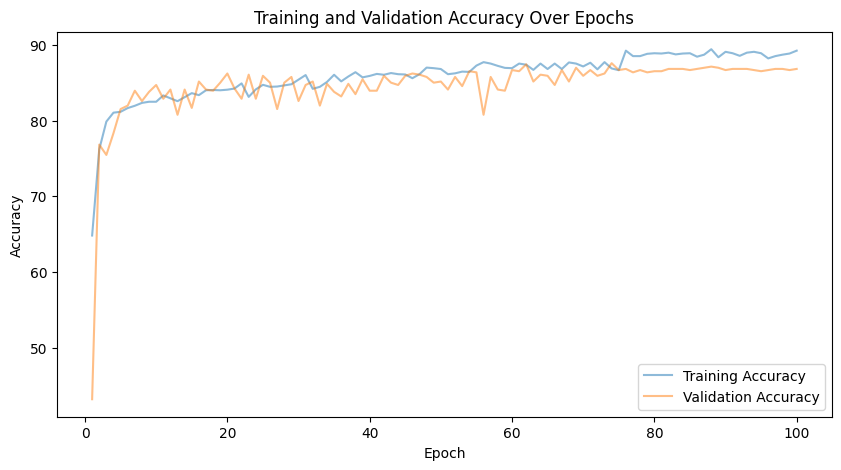

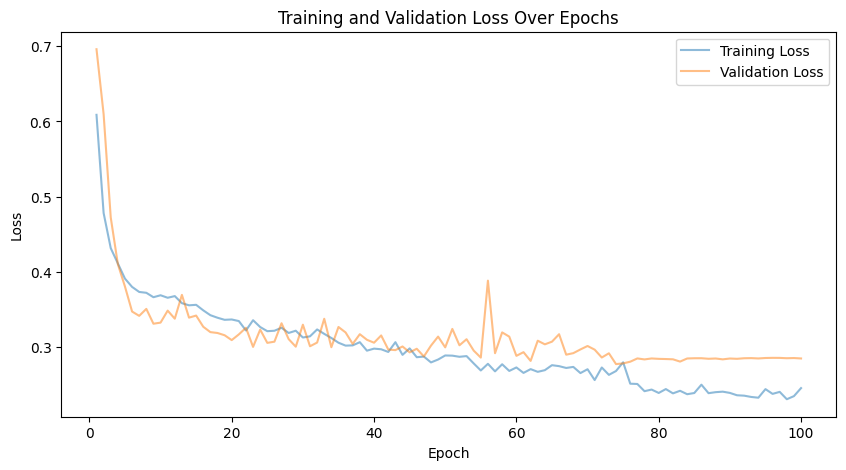

In [33]:
plot_metric('Accuracy', train_accuracies, val_accuracy, epochs=num_epochs)
plot_metric('Loss', train_losses, val_losses, epochs=num_epochs)